# Проект: Защита персональных данных клиентов

## Описание проекта

Нам нужно защитить данные клиентов страховой компании «Хоть потоп». Необходимо разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Корректность работы метода необходимо обосновать. При использовании метода качество моделей машинного обучения не должно ухудшаться.

## Описание данных

Набор данных находится в файле `insurance.csv`.

* **Признаки:** пол, возраст и зарплата застрахованного, количество членов его семьи.
* **Целевой признак:** количество страховых выплат клиенту за последние 5 лет.

## Этапы выполнения проекта

1. Сперва мы загрузим и изучим данные;
2. Ответим на вопрос: изменится ли качество линейной регрессии при преобразовании данных.
3. Предложим алгоритм преобразования данных для решения задачи
4. Запрограммируем этот алгоритм. Проверим качество линейной регрессии из библиотеки *sklearn* с помощью метрики *R2* и сравним результаты до преобразования и после.

## Предварительные настройки

In [1]:
# импортируем необходимые бибилиотеки
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Загрузка данных

In [2]:
# загружаем данные
data = pd.read_csv('insurance.csv')

In [3]:
# проверяем данные
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
# выводим общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Данные загрузились без ошибок и имеют следующую структуру:

* строки это наблюдаемые клиенты;
* столбцы это признаки, описывающие клиента.

Всего наблюдается $5000$ наблюдений, признаки соответствуют описанию данных. Имена признаков не соответствуют хорошему стилю. Пропущенные значения в данных отсутствуют.

Взглянем на уникальные значения признаков *Пол, Члены семьи, Страховые выплаты*, а также на распределение признаков *Возраст* и *Зарплата*.

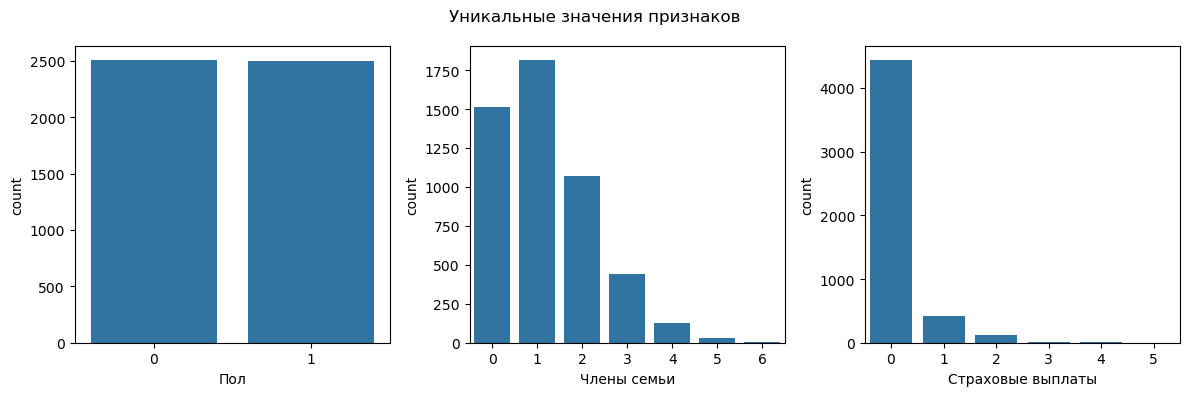

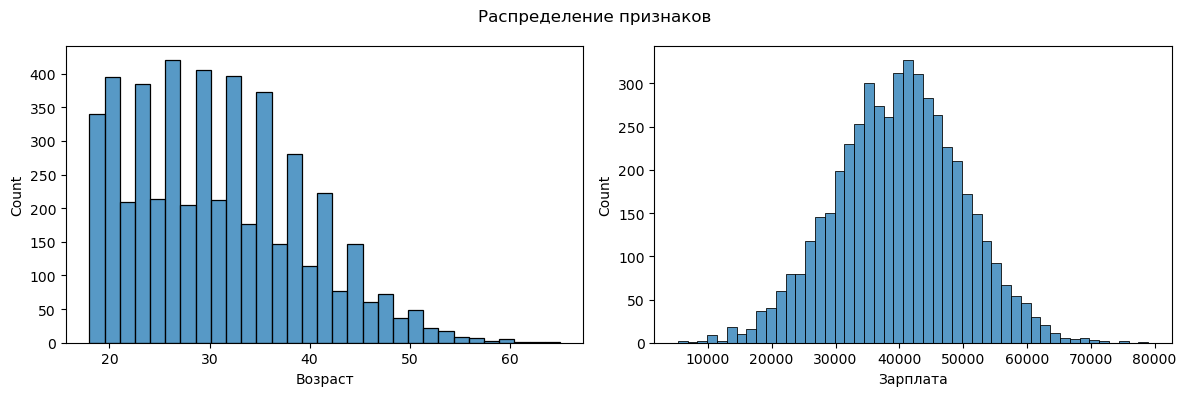

In [5]:
# создаём фигуру
fig, (ax_sex, ax_fam, ax_pay) = plt.subplots(1, 3, figsize=(12, 4))

# рисуем графики первой фигуры
sns.countplot(data=data, x='Пол', ax=ax_sex)
sns.countplot(data=data, x='Члены семьи', ax=ax_fam)
sns.countplot(data=data, x='Страховые выплаты', ax=ax_pay)

# настраиваем первую фигуру
fig.suptitle('Уникальные значения признаков')
plt.tight_layout()

# создаём вторую фигуру
fig, (ax_age, ax_sal) = plt.subplots(1, 2, figsize=(12, 4))

# рисуем графики второй фигуры
sns.histplot(data=data, x='Возраст', ax=ax_age)
sns.histplot(data=data, x='Зарплата', ax=ax_sal)

# настраиваем вторую фигуру
fig.suptitle('Распределение признаков')
plt.tight_layout()

Анализируя графики мы можем сделать следующие выводы:

* Данные содержат практически одинаковое количество наблюдений разных *полов* (мужской и женский);
* Количество *членов семьи* достигает до шести человек включительно. В основном у клиентов наблюдается от $1$ до $2$ человек в семье, а также $0$. Последнее означает, что клиент не имеет семьи;
* Признак *Страховые выплаты* является целевым, дискретным. Уникальные значения достигают пяти выплат за последние $5$ лет. Большая часть наблюдений за этот срок не получала страховых выплат.
* В распределении признаков *Возраст* и *Зарплата* не наблюдается каких-либо аномальных значений.

Теперь проверим данные на дубликаты и исправим имена столбцов согласно хорошему стилю. 

In [6]:
# проверяем наличие дубликатов
print('Обнаружено дубликатов:', data.duplicated().sum())

Обнаружено дубликатов: 153


In [7]:
# удаляем дубликаты
data = data.drop_duplicates().reset_index(drop=True)

# переименовываем столбцы
data = data.rename(columns={
    'Пол': 'sex',
    'Возраст': 'age',
    'Зарплата': 'salary',
    'Члены семьи': 'family',
    'Страховые выплаты': 'payments'
})

# проверяем наличие дубликатов
print('Наличие дубликатов:', data.duplicated().sum())
# проверяем имена столбцов
print('Текущие имена столбцов:', data.columns.tolist())

Наличие дубликатов: 0
Текущие имена столбцов: ['sex', 'age', 'salary', 'family', 'payments']


## Умножение матриц

В качестве метода преобразований данных мы будем использовать умножение матриц — матрицу признаков $X$ на случайную обратимую матрицу $P$. Но сперва мы должны проверить математически, изменится ли качество линейной регрессии в случаем преобразования или нет. Мы знаем, что предсказания вычисляются по сокращённой формуле:

$$a = Xw$$

где:

* $a$ — вектор предсказанных значений,
* $X$ — матрица признаков (нулевой столбец состоит из единиц),
* $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу $w_0$.

Вектор весов вычисляется по следующей формуле:

$$w = (X^T X)^{-1} X^T y$$

где:

* $y$ — вектор значений целевого признака.

Обозначим преобразованные признаки как матрицу $X'$, которая является произведением матрицы признаков $X$ и случайной обратимой матрицы $P$:

$$X' = XP$$

В таком случае вектор весов для преобразованных признаком можно найти по формуле:

$$w' = ((X')^T X')^{-1} (X')^T y$$

или

$$w' = ((XP)^T (XP))^{-1} (XP)^T y$$

Для дальнейшего преобразвоания формулы нам понадобится ряд свойств:

1. $(AB)^T=B^T A^T$
2. $(AB)^{-1} = B^{-1} A^{-1}$
3. $A A^{-1} = A^{-1} A = E$
4. $AE = EA = A$

Воспользуемся первым свойством: 
* раскроем $(XP)^T$ в примере $((XP)^T (XP))^{-1}$, и получим $(P^T X^T XP)^{-1}$; 
* также раскроем $(XP)^T$ в примере $(XP)^T y$, где мы получим $P^T X^T y$.

В результате наша формула быдет выглядеть следующим образом:

$$w' = (P^T X^T XP)^{-1} P^T X^T y$$

Воспользуемся вторым свойством:
* рассмотрим пример $(P^T X^T XP)^{-1}$. Пусть $A=P^T$, а $B=X^T XP$; 
* тогда $(P^T X^T XP)^{-1} = (X^T XP)^{-1} (P^T)^{-1}$, что в результате даст нам следующее:

$$w' = (X^T XP)^{-1} (P^T)^{-1} P^T X^T y$$

В формуле присутствуют обратная матрица $(P^T)^{-1}$ и её исходная матрица $P^T$. Воспользуемся третьим свойством:
* при произведение двух таких матриц мы получим единичную матрицу $E$, то есть $(P^T)^{-1} P^T = E$; 
* согласно четвёртому свойству мы можем опустить единичную матрицу $E$, так как она не приносит каких-либо преобразований:  

$$w' = (X^T XP)^{-1} (P^T)^{-1} P^T X^T y = (X^T XP)^{-1} E X^T y = (X^T XP)^{-1} X^T y$$


Воспользуемся вторым свойством ещё раз: 
* пусть $A=X^T X$, а $B=P$; 
* тогда $(X^T XP)^{-1} = P^{-1} (X^T X)^{-1}$. 

В итоге мы получаем следующую формулу:

$$w' = P^{-1} (X^T X)^{-1} X^T y$$

где $(X^T X)^{-1} X^T y$ является вектором весов линейной регрессии $w$ для признаков без преобразования. Отсюда следует, что ветор весов для преобразованных признаков $w'$ есть произведение обратной случайной матрицы $P$ и вектора весов для признаков без преобразования $w$:

$$w' = P^{-1} w$$

Зная матрицу преобразованных признаков $X'$ и вектор весов для преобразованных признаков $w'$, мы можем найти формулу вектора предсказаных значений для преобразованных признаков:

$$a' = X'w' = XP\cdot P^{-1} w = XEw = Xw = a$$

Данная формула доказывает, что векторы предсказанных значений для перобразованных и не преобразованных признаков будут равны. Исходя из этого при решении задачи обучения будут найдены одни и те же веса:

$$w = \arg\min_w MSE(Xw, y)$$

Это значит, что качество линейной регрессии не изменится при преобразовании признаков, при этом параметры линейной регресии $w$ в исходной задаче являются произведением этих же параметров на обратную случайную матрицу $P^{-1}$ в преобразованой задаче.

## Алгоритм преобразования

Для преобразования данных мы будем умножать матрицу признаков $m\times n$ на случайную матрицу $n \times k$. В результате чего  значения каждого признака будут смещены в пространстве на некоторое значение матрицы. 

$$X' = X @ P$$

Данное преобразвоание не повлияет на качество линейной регрессии, что было доказано на предыдущем этапе проекта. Таким образом мы деперсонализируем наши данные, предоставив некоторую защиту шифрованием.

Важным условием преобразования является наличие обратной матрицы $P^{-1}$, чтобы оставалась возможность произвести обратный процесс шифрования данных. То есть случайная матрица $P$ должна быть обратимой. В таком случае дешифровать данные можно по формуле:

$$X = X' @ P^{-1}$$

Исходя из вышеописанного, алгоритм преобразования может выглядить следующим образом:

1. Генерирование случайной матрицы, высота которой равна ширине матрицы признаков;
2. Проверка случайной матрицы на обратимость. В случае если случайная матрица является необратимой, то алгоритм возвращается к первому шагу;
3. Преобразование матрицы признаков согласно формуле;
4. Получение преобразованных признаков и ключа дешифрования.

## Программирование и проверка алгоритма

Запрограммируем алгоритм, применив матричные преобразования. Сгенерируем случайную матрицу `P` и ключ для дешифрования `key`, найдя обратную матрицу для `P`. Обратимость случайной матрицы мы проверим с помощью определителя: если он будет равен нулю (матрица является необратимой), то будет генерироваться новая случайная матрица до тех пор, пока условие перестанет выполняться. 

In [8]:
# объявляем функцию преобразования
def encrypt_features(X):
    '''
    Функция шифрует значения признаков
    путём произведения матрицы признаков
    на случайную матрицу. При этом создаётся ключ 
    для дешифрования значений признаков.
    
    Параметры:
    ----------
    X : DataFrame
        Датафрейм независимых признаков.
    
    Возвращает:
    -----------
    Функция возварщает кортеж
    из зашифрованных значений признаков
    и ключа для дешифрования.
    '''
    # получаем ширину матрицы признаков     
    weight = X.shape[1]
    # генерируем случайную матрицу для преобразования
    P = np.random.normal(size=(weight, weight))
    
    # проверяем обратимость случайной матрицы:      
    # пока определитель равен нулю
    while np.linalg.det(P) == 0:
        # генерируем новую случайную матрицу
        P = np.random.normal(size=(weight, weight))
        
    # создаём ключ для дешифрования
    key = np.linalg.inv(P)
    # производим преобразование
    X_tranformed = X.values @ P
    
    # возвращаем результат
    return X_tranformed, key

Далее разделим признаки на независимые и целевые, и преобразуем независимые признаки с помощью нашей функции.

In [9]:
# разделяем признаки
X = data.drop('payments', axis=1)
y = data['payments']

# применяем функцию шифрования
X_transformed, key = encrypt_features(X)

# проверяем результат преобразования
pd.DataFrame(X_transformed).head()

,0,1,2,3
0,-38625.027404,-21324.553786,32427.583218,5758.625813
1,-29576.468562,-16319.445274,24847.541678,4408.218859
2,-16341.587251,-9014.264397,13731.538105,2434.805860
3,-32485.405296,-17944.278015,27262.320141,4846.133819
4,-20319.007943,-11213.493040,17063.858736,3027.988442


Мы получили преобразованные данные, по которым сложно восстановить персональную информацию без ключа дешифровки.

Теперь обучим линейную регрессию на признаках и сравним качество модели на преобразованных признаках и признаках без преобразования с помощью кросс-валидации. Значение не должно отличаться более чем на $1\%$.    

In [10]:
# проверяем модели
score_normal = cross_val_score(LinearRegression(), X, y)
score_transform = cross_val_score(LinearRegression(), X_transformed, y)

# выводим результаты на экран
print('Качество модели на признаках без преобразования:', score_normal.mean())
print('-' * 67)
print('Качество модели на преобразованных признаках:', score_transform.mean())
print('-' * 67)

Качество модели на признаках без преобразования: 0.42779425802804977
-------------------------------------------------------------------
Качество модели на преобразованных признаках: 0.42779425802596505
-------------------------------------------------------------------


Качество моделей до преобразований и после не различается. Мы экспериментально подтвердили наше математическое доказательство. В заключении попробуем дешифровать преобразованные данные и сравнить их с исходными.

In [11]:
# возвращаем данные к начальному виду
X_decrypted = X_transformed @ key

# проверяем результат и выводим исходные данные
display(
    pd.DataFrame(X_decrypted.round(), columns=X.columns).head(),
    X.head()
)

,sex,age,salary,family
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0


,sex,age,salary,family
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0


Данные после дешифрования совпадают с исходными данными. Алгоритм шифрования и дефишрования работает корректно и готов к использованию.

# Общий вывод

Целью данного проекта являлась разработка метода преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Это необходимо для защиты персональных данных клиентов страховой компании «Хоть потоп». Нужно защитить данные таким образом, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Корректность работы метода необходимо было обосновать.

Первым делом мы получили файл с данными, загрузили их и изучили. Удалось выяснить следующее:

* строки в данных это наблюдаемые клиенты;
* столбцы — это признаки, описывающие клиента.

Всего наблюдается $5000$ наблюдений, признаки соответствуют следующему описанию:

* Признаки: *пол, возраст* и *зарплата застрахованного, количество членов его семьи*;
* Целевой признак: *количество страховых выплат* клиенту за последние 5 лет.

Имена признаков не соответствуют хорошему стилю. Пропущенные значения в данных отсутствуют. Мы проанализировали признаки на графиках и выяснили следующее:

* Данные содержат практически одинаковое количество наблюдений разных *полов* (мужской и женский);
* *Количество членов семьи* достигает до шести человек включительно. В основном у клиентов наблюдается от $1$ до $2$ человек в семье, а также $0$. Последнее означает, что клиент не имеет семьи;
* Признак *cтраховые выплаты* является целевым, дискретным. Уникальные значения достигают пяти выплат за последние $5$ лет. Большая часть наблюдений за этот срок не получала страховых выплат.
* В распределении признаков *возраст* и *зарплата* не наблюдается каких-либо аномальных значений.

Далее мы проверили данные на явные дубликаты. Было обнаружено 153 дублированных строки. Мы удалили эти дубликаты, а также переименовали столбцы согласно хорошему стилю написания.

В качестве метода преобразований данных было выбрано умножение матрицы признаков на случайную обратимую матрицу. Мы математически доказали, что при использовании данного метода качество моделей не изменится — векторы предсказанных значений для перобразованных и не преобразованных признаков будут равны. 

Важным условием преобразования является наличие обратной матрицы преобразования, чтобы у нас оставалась возможность произвести обратный процесс шифрования данных. В этом случае мы должны шифрованные данные умножить на матрицу, обратную сгенерированной случайной.

Мы выбрали следующий алгоритм преобразования:

1. Сначала мы генерируем случайную матрицу, высота которой равна ширине матрицы признаков;
2. Проверяем случайную матрицу на обратимость. В случае если случайная матрица является необратимой, то мы возвращается к первому шагу;
3. Генерируем ключ дешифровки, найдя обратную матрицу случайной;
4. Преобразовываем матрицу признаков, умножая её на сгенерированную матрицу;
5. В случае дешифрования данных преобращзованные данные умножаем на матрицу, обратную сгенерированной.

Мы запрограммировали алгоритм, применив матричные преобразования и применили его. В результате мы получили преобразованные данные, по которым сложно восстановить персональную информацию без ключа дешифровки.

Далее мы обучили и проверили модели с помощью кросс-валидации на преобразованных данных и данных без преобразования. Качество моделей не различается, что подтверждает наше математическое доказательство. 

Для подтверждения корректности работы метода преобразования мы с помощью полученного ключа произвели процесс дешифрования данных и сравнили их с исходными. Различий не обнаружено, метод преобразования персональных данных реализован, проверен и готов к использованию. 